# Statistics

After running your MIKE simulation, you would often want to make different kinds of summary statistics of your data - both for your own understanding and for communicating your results.

Examples of statistics

* Min, max, mean, standard deviation 
* Quantiles/percentiles (e.g. median, interquartile range, return period etc)
* Probability/frequency of exceedance

Types of aggregations

* Total - aggregate all data to a single number 
* Temporal - aggregate all time steps; for a dfsu 2d, the result would be a map
* Spatial - aggregate all elements to a single value per time step
* Others: monthly, by layer, spatial bin, sub domain etc... 

Ways of calculating

* [mikeio.Dataset](https://dhi.github.io/mikeio/api/Dataset.html) (or [mikeio.DataArray](https://dhi.github.io/mikeio/api/DataArray.html))
* [mikeio.generic](https://dhi.github.io/mikeio/api/generic.html) (temporal aggregations only; larger-than-memory)
* custom code (typically with NumPy)


In [1]:
import mikeio
import mikeio.generic as generic

## Dataset / DataArray

For smaller dfs files (maybe up to 2GB) it can be convenient to read the data to memory before doing aggregations. The MIKEIO.Dataset class have several [methods](https://dhi.github.io/mikeio/dataset.html#methods) for aggregating data along an axis. See the generic section below for larger-than-memory data. 

In [2]:
ds = mikeio.read("data/NorthSea_HD_and_windspeed.dfsu")
ds

<mikeio.Dataset>
dims: (time:67, element:958)
time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00 (67 records)
geometry: Dfsu2D (958 elements, 570 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)

### Temporal aggregations: mean

The default is to aggregate along the time axis - the output will therefore be a map.

In [3]:
dsm  = ds.mean()
mean_ws = dsm["Wind speed"]
mean_ws.shape

(958,)

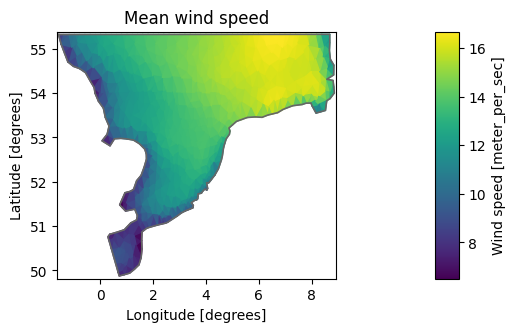

In [4]:
mean_ws.plot(title="Mean wind speed");

### Spatial aggregations 

The Dataset aggregation methods (e.g. mean) takes an `axis` argument. If we give it the spatial axis (or the string 'space'), it will produce a time series of spatially aggregated values. 


:::{note}
It's important to note that the spatial aggregations here ignores element areas! Only average takes a weights argument. 
:::

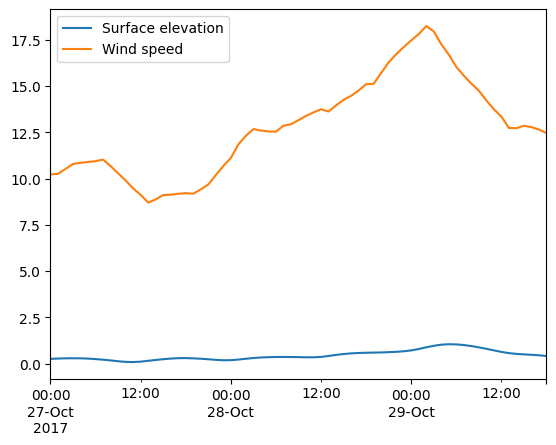

In [36]:
ds.mean(axis="space").plot();

Dataset/DataArray has other methods for calculating typical statistics, e.g. max, quantile...

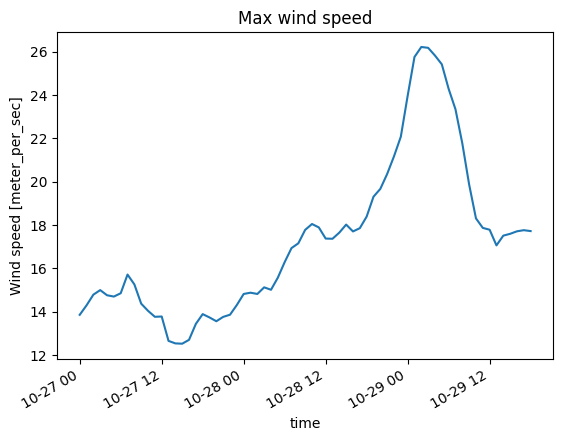

In [9]:
ds.Wind_speed.max(axis="space").plot(title="Max wind speed");

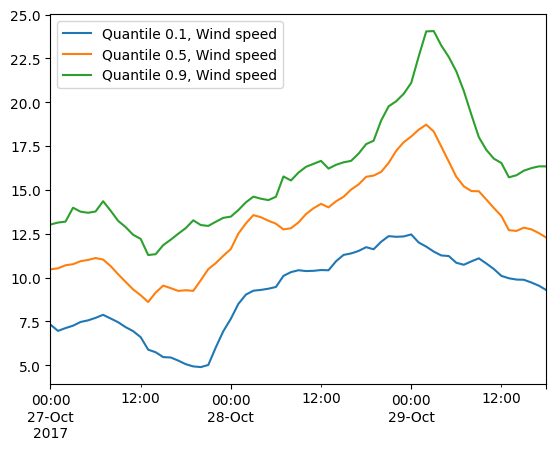

In [10]:
ds.Wind_speed.quantile(q=[0.1,0.5,0.9],axis="space").plot();

It's important to know that the element area is not taking into account when doing the spatial aggregations! Only Dataset.average supports weighted averages.

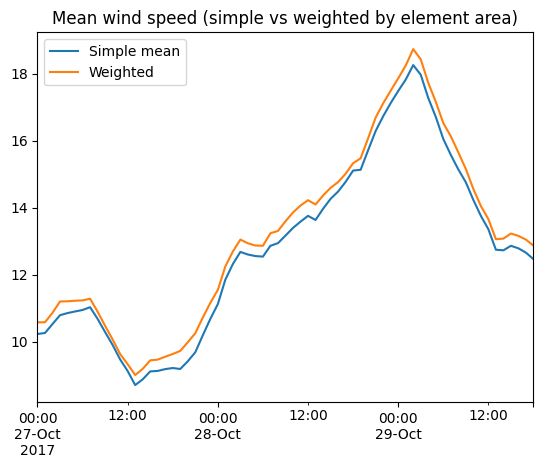

In [13]:
df = ds[["Wind speed"]].mean(axis="space").to_dataframe().rename(columns={"Wind speed":"Simple mean"})

area=ds.geometry.get_element_area()
df['Weighted'] = ds[["Wind speed"]].average(axis="space", weights=area).to_dataframe()

df.plot(title="Mean wind speed (simple vs weighted by element area)");

In [57]:
ds

<mikeio.Dataset>
dims: (time:67, element:958)
time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00 (67 records)
geometry: Dfsu2D (958 elements, 570 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)

**Inline exercise**

1. Create a new DataArray with the temporal mean of the Surface elevation $\eta$

2. Create a new DataArray with the Surface elevation anomaly, $ \eta - \overline{\eta} $

3. Plot the last time step of the anomaly

In [38]:
# insert your code here

### Quantiles to file

In [14]:
dsq  = ds.quantile(q=[0.1,0.5,0.9])
dsq

<mikeio.Dataset>
dims: (element:958)
time: 2017-10-27 00:00:00 (time-invariant)
geometry: Dfsu2D (958 elements, 570 nodes)
items:
  0:  Quantile 0.1, Surface elevation <Surface Elevation> (meter)
  1:  Quantile 0.5, Surface elevation <Surface Elevation> (meter)
  2:  Quantile 0.9, Surface elevation <Surface Elevation> (meter)
  3:  Quantile 0.1, Wind speed <Wind speed> (meter per sec)
  4:  Quantile 0.5, Wind speed <Wind speed> (meter per sec)
  5:  Quantile 0.9, Wind speed <Wind speed> (meter per sec)

Write to a new dfsu file

In [15]:
dsq.to_dfs("NorthSea_Quantiles.dfsu")

![](images/mikezero_quantiles.png)

### Total

Aggregating over all data (both time and space) can be done from the Dataset in a few ways: 

* ds.describe() - will give you summary statistics like pandas df.describe()
* using axis=None in ds.mean(), ds.min()
* using standard NumPy aggregation functions on the Dataset data e.g. ds["Wind speed"].mean()

In [16]:
ds.describe()

,Surface elevation,Wind speed
count,64186.000000,64186.000000
mean,0.449857,12.772705
std,0.651157,3.694293
min,-2.347003,1.190171
25%,0.057831,10.376003
50%,0.466257,12.653086
75%,0.849586,14.885848
max,3.756879,26.213045


In [19]:
ds.min(axis=None).to_dataframe()

,Surface elevation,Wind speed
2017-10-27,-2.347003,1.190171


In [20]:
ds["Wind speed"].values.min()

1.1901706

## Generic

The [MIKEIO.generic](https://dhi.github.io/mikeio/generic.html) submodule can produce common **temporal** statistics on any dfs file (of any size). The output will be a new dfs file. Currently, generic has these methods for calculating statistics: 

* avg_time()
* quantile()

In [21]:
generic.avg_time("data/NorthSea_HD_and_windspeed.dfsu", "NorthSea_avg.dfsu")

100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 18173.85it/s]


In [22]:
ds = mikeio.read("NorthSea_avg.dfsu", items="Wind speed")
ds

<mikeio.Dataset>
dims: (time:1, element:958)
time: 2017-10-27 00:00:00 (time-invariant)
geometry: Dfsu2D (958 elements, 570 nodes)
items:
  0:  Wind speed <Wind speed> (meter per sec)

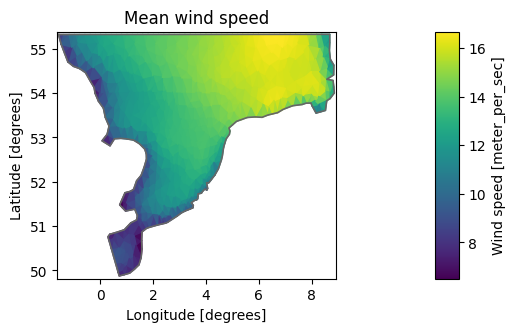

In [23]:
ds["Wind speed"].plot(title="Mean wind speed");

In [24]:
generic.quantile("data/NorthSea_HD_and_windspeed.dfsu", "NorthSea_Quantiles2.dfsu", q=[0.1, 0.5, 0.9])

![](images/mikezero_quantiles.png)

## Custom



In [25]:
ds = mikeio.read("data/NorthSea_HD_and_windspeed.dfsu")

### Dataset.aggregate

With aggregate we can get Dataset statistics with our "own" function, e.g. standard deviation:

In [26]:
import numpy as np
dsa = ds.aggregate(func=np.std)

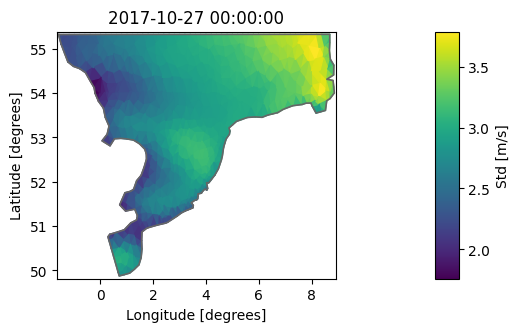

In [27]:
dsa["Wind speed"].plot(label="Std [m/s]");

### Exceedance probability

Let's find out how often the wind exceeds 12m/s in our simulation.

In [28]:
import matplotlib.pyplot as plt

In [29]:
nt = ds.n_timesteps
one_to_zero = 1. - np.arange(1., nt + 1.)/nt

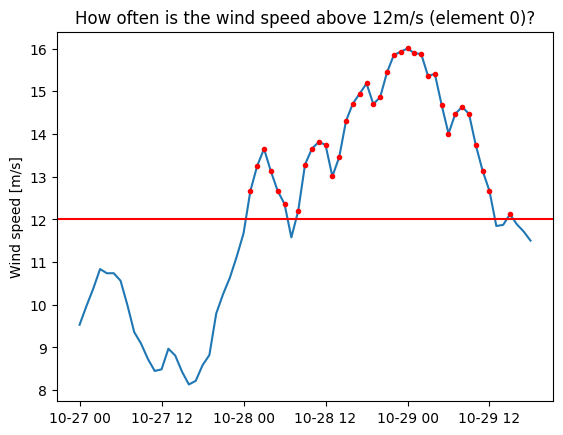

In [30]:
val = ds["Wind speed"].isel(element=0).values
plt.plot(ds.time, val);
plt.plot(ds.time[val>12], val[val>12],'.r');
plt.axhline(y=12,color='r')
plt.ylabel('Wind speed [m/s]')
plt.title('How often is the wind speed above 12m/s (element 0)?');


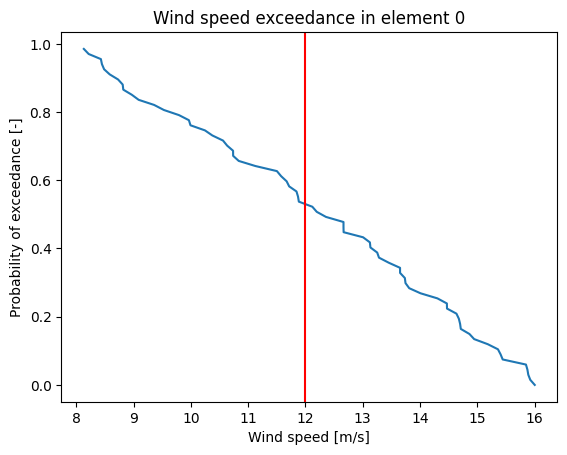

In [31]:
plt.plot(np.sort(val), one_to_zero);
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Probability of exceedance [-]')
plt.axvline(x=12,color='r')
plt.title('Wind speed exceedance in element 0');

In [32]:
# Create empty DataArray 
item=mikeio.ItemInfo(mikeio.EUMType.Probability)
data = np.full(shape=(1,ds.geometry.n_elements), fill_value=np.nan)
dae = mikeio.DataArray(data=data, time="2017-10-27", item=item, geometry=ds.geometry)

In [33]:
threshold = 12
for j in range(ds.n_elements):
    # this is a naive and slow way of calculating this!
    dat = ds["Wind speed"][:,j].values
    dae[0,j] = np.interp(threshold, np.sort(dat), one_to_zero)

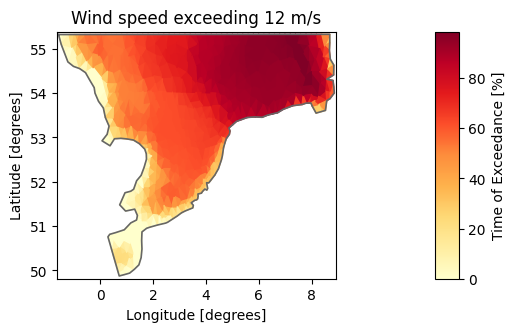

In [34]:
dae100 = dae*100
dae100.plot(title="Wind speed exceeding 12 m/s", 
    label="Time of Exceedance [%]", cmap="YlOrRd");

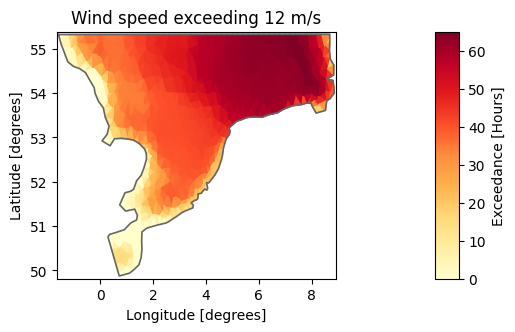

In [35]:
total_hours = (ds.time[-1]-ds.time[0]).total_seconds()/3600
dae_hours = dae*total_hours
dae_hours.plot(title="Wind speed exceeding 12 m/s", 
    label="Exceedance [Hours]", cmap="YlOrRd");